In [1]:
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass, replace
from pyvis.network import Network
from pyvis.options import Layout
import time

In [2]:
def phi(f, alpha):
    return 1 - (1-f)**alpha

In [3]:
@dataclass
class Block:
    id: int
    slot: int
    height: int
    parent: int
    leader: int

In [4]:
@dataclass
class NetworkParams:
    broadcast_delay_mean: int # second
    pol_proof_time: int # seconds
    # ---- blend network -- 
    blending_delay: int
    desimenation_delay_mean: float
    # desimenation_delay_var: float
    blend_hops: int
    no_network_delay: bool = False

    def sample_blending_delay(self):
        return np.random.uniform(0, self.blending_delay)

    def sample_desimenation_delay(self):
        return np.random.exponential(self.desimenation_delay_mean)
        # scale = self.desimenation_delay_var / self.desimenation_delay_mean
        # shape = self.desimenation_delay_mean / scale
        # return np.random.gamma(shape=shape, scale=scale)

    def sample_blend_network_delay(self):
        return sum(self.sample_blending_delay() + self.sample_desimenation_delay() for _ in range(self.blend_hops))
    
    def sample_broadcast_delay(self, blocks):
        return np.random.exponential(self.broadcast_delay_mean, size=blocks.shape)

    def block_arrival_slot(self, block_slot):
        if self.no_network_delay:
            return block_slot
        # return self.pol_proof_time + self.sample_mixnet_delay() + self.sample_broadcast_delay(block_slot) + block_slot
        return self.pol_proof_time + self.sample_blend_network_delay() + self.sample_broadcast_delay(block_slot) + block_slot

    def empirical_network_delay(self, N=10000, M=1000):
        return np.array([self.block_arrival_slot(np.zeros(M)) for _ in range(N)]).reshape(N*M)

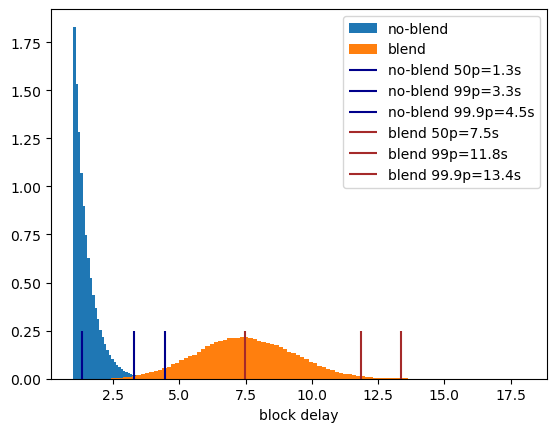

In [5]:
blend_net = NetworkParams(
    broadcast_delay_mean=0.5,
    pol_proof_time=1,
    blending_delay=3,
    desimenation_delay_mean=0.5,
    blend_hops=3,
)
no_blend_net = replace(blend_net, blend_hops=0)

N = 100
M = 10000
no_blend_samples = no_blend_net.empirical_network_delay()
no_blend_mean = no_blend_samples.mean()
blend_samples = blend_net.empirical_network_delay()
blend_mean = blend_samples.mean()

_ = plt.hist(no_blend_samples, bins=100, density=True, label="no-blend")
_ = plt.hist(blend_samples, bins=100, density=True, label="blend")

for p in [50, 99, 99.9]:
    no_blend_pct = np.percentile(no_blend_samples, p)
    _ = plt.vlines(no_blend_pct, ymin=0, ymax=0.25, color='darkblue', label=f"no-blend {p}p={no_blend_pct:.1f}s")

for p in [50, 99, 99.9]:
    blend_pct = np.percentile(blend_samples, p)
    _ = plt.vlines(blend_pct, ymin=0, ymax=0.25, color='brown', label=f"blend {p}p={blend_pct:.1f}s")
# _ = plt.vlines(blend_mean, ymin=0, ymax=1, color='brown', label=f"blend 50p={blend_mean:.1f}s")
# _ = plt.hist(blend_net.block_arrival_slot(np.zeros(1000)), bins=100, density=True, label="blend")
_ = plt.legend()
_ = plt.xlabel("block delay")

In [6]:
@dataclass
class Params:
    SLOTS: int
    f: float
    honest_stake: np.array
    adversary_control: float

    @property
    def N(self):
        return len(self.honest_stake) + 1

    @property
    def stake(self):
        return np.append(self.honest_stake, self.honest_stake.sum() / (1/self.adversary_control - 1))
    
    @property
    def relative_stake(self):
        return self.stake / self.stake.sum()

    def slot_prob(self):
        return phi(self.f, self.relative_stake)

In [7]:
class Sim:
    def __init__(self, params: Params, network: NetworkParams):
        self.params = params
        self.network = network
        self.leaders = np.zeros((params.N, params.SLOTS), dtype=np.int64)
        self.blocks = []
        max_number_of_blocks = int(3 * params.SLOTS * params.f)
        self.block_slots = np.zeros(max_number_of_blocks, dtype=np.int64)
        self.block_heights = np.zeros(max_number_of_blocks, dtype=np.int64)
        self.block_arrivals = np.zeros(shape=(params.N, max_number_of_blocks), dtype=np.int64) # arrival time to each leader for each block
        self.block_arrivals[:,:] = self.params.SLOTS
        # self.block_arrivals = np.zeros(shape=(params.N, 0), dtype=np.int64) # arrival time to each leader for each block

    
    def emit_block(self, leader, slot, height, parent):
        assert type(leader) in [int, np.int64]
        assert type(slot) in [int, np.int64]
        assert type(height) in [int, np.int64]
        assert type(parent) in [int, np.int64]

        block = Block(
            id=len(self.blocks),
            slot=slot,
            height=height,
            parent=parent,
            leader=leader,
        )
        self.blocks.append(block)
        self.block_slots[block.id] = block.slot
        self.block_heights[block.id] = block.height
    
        # decide when this block will arrive at each node
        new_block_arrival_by_node = self.network.block_arrival_slot(np.repeat(block.slot, self.params.N))

        if parent != -1:
            # the new block cannot arrive before it's parent
            parent_arrival_by_node = self.block_arrivals[:,parent]
            new_block_arrival_by_node = np.maximum(new_block_arrival_by_node, parent_arrival_by_node)

        self.block_arrivals[:,block.id] = new_block_arrival_by_node
        # self.block_arrivals = np.append(self.block_arrivals, new_block_arrival_by_node.reshape((self.params.N, 1)), axis=1)

        return block.id

    def emit_leader_block(self, leader, slot):
        assert type(leader) in [int, np.int64], type(leader)
        assert isinstance(slot, int)

        parent = self.fork_choice(leader, slot)
        return self.emit_block(
            leader,
            slot,
            height=self.blocks[parent].height + 1,
            parent=parent,
        )

    def fork_choice(self, leader, slot):
        assert type(leader) in [int, np.int64], type(leader)
        assert isinstance(slot, int)
        arrived_blocks = (self.block_arrivals[leader, :len(self.blocks)] <= slot) * self.block_heights[:len(self.blocks)]
        concurrent = (arrived_blocks == np.max(arrived_blocks)).nonzero()[0]
        return np.random.choice(concurrent)

    def plot_spacetime_diagram(self, MAX_SLOT=1000):
        alpha_index = sorted(range(self.params.N), key=lambda n: self.params.relative_stake[n])
        nodes = [f"$N_{n}$($\\alpha$={self.params.relative_stake[n]:.2f})" for n in alpha_index]
        messages = [(nodes[alpha_index.index(self.blocks[b].leader)], nodes[alpha_index.index(node)], self.blocks[b].slot, arrival_slot, f"$B_{{{b}}}$") for b, arrival_slots in enumerate(self.block_arrivals[:,:len(self.blocks)].T) for node, arrival_slot in enumerate(arrival_slots) if arrival_slot < MAX_SLOT]
    
        fig, ax = plt.subplots(figsize=(8,4))
        
        # Plot vertical lines for each node
        max_slot = max(s for _,_,start_t, end_t,_ in messages for s in [start_t, end_t])
        for i, node in enumerate(nodes):
            ax.plot([i, i], [0, max_slot], 'k-', linewidth=0.1)
            ax.text(i, max_slot + 30 * (0 if i % 2 == 0 else 1), node, ha='center', va='bottom')
        
        # Plot messages
        colors = plt.cm.rainbow(np.linspace(0, 1, len(messages)))
        for (start, end, start_time, end_time, label), color in zip(messages, colors):
            start_idx = nodes.index(start)
            end_idx = nodes.index(end)
            ax.annotate('', xy=(end_idx, end_time), xytext=(start_idx, start_time),
                        arrowprops=dict(arrowstyle='->', color="black", lw=0.5))
            placement = 0
            mid_x = start_idx * (1 - placement) + end_idx * placement
            mid_y = start_time * (1 - placement) + end_time * placement
            ax.text(mid_x, mid_y, label, ha='center', va='center', 
                    bbox=dict(facecolor='white', edgecolor='none', alpha=0.7))
        
        ax.set_xlim(-1, len(nodes))
        ax.set_ylim(0, max_slot + 70)
        ax.set_xticks(range(len(nodes)))
        ax.set_xticklabels([])
        # ax.set_yticks([])
        ax.set_title('Space-Time Diagram')
        ax.set_ylabel('Slot')
        
        plt.tight_layout()
        plt.show()

    def honest_chain(self):
        chain_head = max(self.blocks, key=lambda b: b.height)
        honest_chain = {chain_head.id}
        
        curr_block = chain_head
        while curr_block.parent >= 0:
            honest_chain.add(curr_block.parent)
            curr_block = self.blocks[curr_block.parent]
        return sorted(honest_chain, key=lambda b: self.blocks[b].height)

    def visualize_chain(self):
        honest_chain = self.honest_chain()
        print("Honest chain length", len(honest_chain))
        honest_chain_set = set(honest_chain)
        
        layout = Layout()
        layout.hierachical = True
        
        G = Network(width=1600, height=800, notebook=True, directed=True, layout=layout, cdn_resources='in_line')

        for block in self.blocks:
            # level = slot
            level = block.height
            color = "lightgrey"
            if block.id in honest_chain_set:
                color = "orange"

            G.add_node(int(block.id), level=level, color=color, label=f"{block.id},{block.slot}")
            if block.parent >= 0:
                G.add_edge(int(block.id), int(block.parent), width=2, color=color)
        
        return G.show("chain.html")

    def run(self, seed=None):
        from collections import defaultdict
        timings = defaultdict(float)
        start_t = time.time()
        if seed is not None:
            np.random.seed(seed)

        # emit the genesis block
        self.emit_block(
            leader=0,
            slot=0,
            height=1,
            parent=-1,
        )
        self.block_arrivals[:,0] = 0 # all nodes see the genesis block

        prep_t = time.time()


        for s in range(1, self.params.SLOTS):
            slot_start_t = time.time()
            # the adversary will not participate in the simulation
            # (implemented by never delivering blocks to the adversary)
            # self.block_arrivals[-1,:] = self.params.SLOTS

            self.leaders[:,s] = np.random.random(size=self.params.N) < self.params.slot_prob()
            leader_lottery_t = time.time()

            for leader in np.nonzero(self.leaders[:,s])[0]:
                lead_start_t = time.time()
                if self.params.adversary_control is not None and leader == self.params.N - 1:
                    continue
                
                parent = self.fork_choice(leader, s)
                fork_choice_t = time.time()
                
                self.emit_block(
                    leader,
                    s,
                    height=self.blocks[parent].height + 1,
                    parent=parent,
                )
                emit_leader_block_t = time.time()

                timings["forkchoice"] += fork_choice_t - lead_start_t
                timings["emit_leader_block"] += emit_leader_block_t - fork_choice_t
                    
                # self.emit_leader_block(leader, s)
            slot_end_t = time.time()
            timings["leader"] += leader_lottery_t - slot_start_t
            timings["emit"] += slot_end_t - leader_lottery_t
            timings["slot"] += slot_end_t - slot_start_t

        end_t = time.time()
        timings["prep"] = prep_t - start_t
        timings["total"] = end_t - start_t
        for phase, duration in timings.items():
            print(f"{phase}\t{duration:.2f}s")

    def adverserial_analysis(self, should_plot=False, seed=0):
        from collections import defaultdict

        timings = defaultdict(float)

        start_t = time.time()
        np.random.seed(seed)
        
        adversary = self.params.N-1 # adversary is always the last node in our simulations

        self.block_arrivals[adversary,:len(self.blocks)] = self.block_slots[:len(self.blocks)] # we will say the adversary receives the blocks immidiately

        honest_chain = self.honest_chain()
        
        honest_chain_t = time.time()
        
        honest_height_by_slot = np.zeros(self.params.SLOTS, dtype=np.int64)

        for block_id in honest_chain:
            honest_height_by_slot[self.blocks[block_id].slot] = 1
        honest_height_by_slot = honest_height_by_slot.cumsum()
        
        honest_height_by_slot_t = time.time()
        
        reorg_depths = []
        if should_plot:
            plt.figure(figsize=(20, 6))
            ax = plt.subplot(121)
        
        adversary_active_slots = np.random.random(size=self.params.SLOTS) < phi(self.params.f, self.params.relative_stake[adversary])
        adversary_cumsum = adversary_active_slots.cumsum()

        all_active_slots = (self.leaders.sum(axis=0) + adversary_active_slots) > 0

        advantage = np.zeros(self.params.SLOTS)
        prep_t = time.time()
        timings["honest_chain"] += honest_chain_t - start_t
        timings["honest_height_by_slot"] += honest_height_by_slot_t - honest_chain_t
        timings["prep_analysis"] += prep_t - start_t
        for b in range(len(self.blocks)):
            block_start_t = time.time()
            block = self.blocks[b]
            if block.id > 0 and block.id % 5000 == 0:
                print("Processing block", block)
            
            nearest_honest_block = block
            while nearest_honest_block.height >= len(honest_chain) or honest_chain[nearest_honest_block.height-1] != nearest_honest_block.id:
                nearest_honest_block = self.blocks[nearest_honest_block.parent]

            nearest_honest_t = time.time()
            
            cumulative_rel_height = adversary_cumsum[block.slot+1:] - adversary_cumsum[block.slot]

            adverserial_height_by_slot = block.height + cumulative_rel_height

            honest_height_by_slot_lookahead = honest_height_by_slot[block.slot + 1:]
        
            adverserial_wins = adverserial_height_by_slot > honest_height_by_slot_lookahead
        
            reorg_events = adverserial_wins & all_active_slots[block.slot+1:]

                
            reorg_events_t = time.time()
            reorg_depth = honest_height_by_slot_lookahead[reorg_events] - nearest_honest_block.height
            reorg_depth_t = time.time()
            reorg_depths += list(reorg_depth)
            block_end_t = time.time()
            timings["nearest_honest"] += nearest_honest_t - block_start_t
            timings["reorg_events"] += reorg_events_t - nearest_honest_t
            timings["reorg_depth"] += reorg_depth_t - reorg_events_t
            timings["depth_append"] += block_end_t - reorg_depth_t
            
            if should_plot:
                if reorg_events.sum() > 0:
                    first_slot = block.slot+1
                    last_slot = first_slot + np.nonzero(reorg_events)[0].max() + 1
                    advantage[first_slot:last_slot] = np.maximum(advantage[first_slot:last_slot], adverserial_height_by_slot[:last_slot-first_slot]-honest_height_by_slot[first_slot:last_slot])

        for phase, duration in timings.items():
            print(f"{phase}\t{duration:.2f}s")
                    
        if should_plot:
            ax.plot(advantage, color='k', lw="0.5")
            _ = ax.set_title(f"max chain weight with adversery controlling {self.params.relative_stake[adversary] * 100:.0f}% of stake")
            _ = ax.set_ylabel("adversary height advantage")
            _ = ax.set_xlabel("slot")
            _ = ax.legend()

            ax = plt.subplot(122)
            _ = ax.grid(True)
            _ = ax.hist(reorg_depths, density=False, bins=100)
            _ = ax.set_title(f"re-org depth with {self.params.relative_stake[adversary] * 100:.0f}% adversary")
            _ = ax.set_xlabel("re-org depth")
            _ = ax.set_ylabel("frequency")
        return reorg_depths

In [8]:
%%time
np.random.seed(0)
sim = Sim(
    params=Params(
        SLOTS=1000,
        f=1/5,
        adversary_control = 0.3,
        honest_stake = np.random.pareto(10, 1000)
    ),
    network=blend_net
)
sim.run(seed=0)

n_blocks_per_slot = len(sim.blocks) / sim.params.SLOTS
print("avg blocks per slot", n_blocks_per_slot)
print("Number of blocks", len(sim.blocks))
print("longest chain", max(b.height for b in sim.blocks))

leader	0.02s
emit	0.01s
slot	0.03s
forkchoice	0.00s
emit_leader_block	0.00s
prep	0.00s
total	0.03s
avg blocks per slot 0.168
Number of blocks 168
longest chain 95
CPU times: user 27.2 ms, sys: 1.37 ms, total: 28.6 ms
Wall time: 27.8 ms


honest_chain	0.00s
honest_height_by_slot	0.00s
prep_analysis	0.00s
nearest_honest	0.00s
reorg_events	0.00s
reorg_depth	0.00s
depth_append	0.00s


/tmp/ipykernel_24758/682093512.py:279: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  _ = ax.legend()


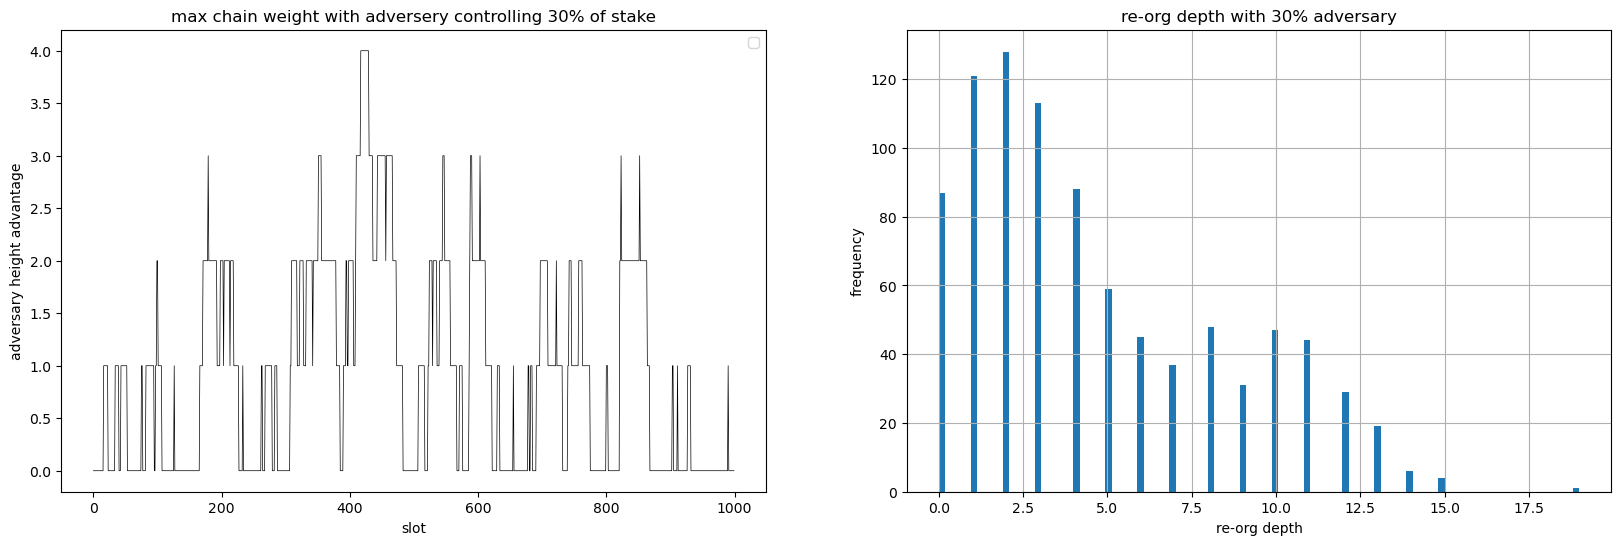

In [9]:
_ = sim.adverserial_analysis(should_plot=True)

In [10]:
# sim.visualize_chain()

In [11]:
%%time
np.random.seed(0)
stake = np.random.pareto(10, 100)

sims = [Sim(
    params=Params(
        SLOTS=100000,
        f=0.05,
        adversary_control = i,
        honest_stake = stake
    ),
    network=blend_net
) for i in np.linspace(1e-3, 0.3, 2)]

for i, sim in enumerate(sims):
    print(f"simulating {i+1}/{len(sims)}")
    sim.run(seed=0)

print("finished simulation, starting analysis")
advs = [sim.adverserial_analysis(should_plot=False) for sim in sims]

simulating 1/2
leader	0.84s
emit	0.22s
slot	1.06s
forkchoice	0.06s
emit_leader_block	0.06s
prep	0.00s
total	1.08s
simulating 2/2
leader	0.83s
emit	0.18s
slot	1.01s
forkchoice	0.04s
emit_leader_block	0.04s
prep	0.00s
total	1.03s
finished simulation, starting analysis
Processing block Block(id=5000, slot=98845, height=3776, parent=np.int64(4999), leader=np.int64(18))
honest_chain	0.00s
honest_height_by_slot	0.00s
prep_analysis	0.01s
nearest_honest	0.00s
reorg_events	0.14s
reorg_depth	0.01s
depth_append	0.00s
honest_chain	0.00s
honest_height_by_slot	0.00s
prep_analysis	0.00s
nearest_honest	0.00s
reorg_events	0.10s
reorg_depth	0.01s
depth_append	0.00s
CPU times: user 2.36 s, sys: 50.7 ms, total: 2.41 s
Wall time: 2.39 s


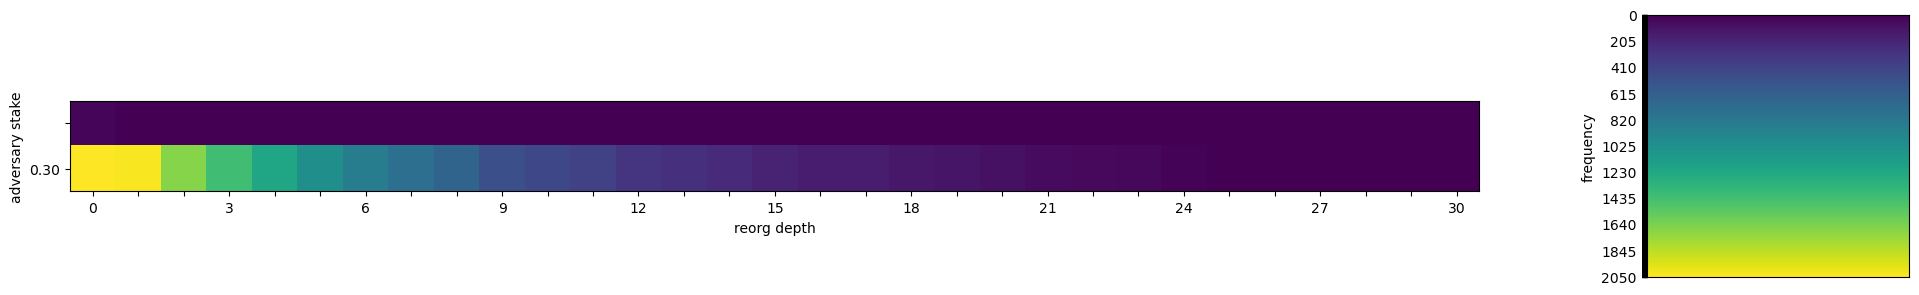

In [12]:
max_reorg_depth = max(max(a) if len(a) > 0 else 0 for a in advs)


heatmap = np.zeros((len(advs), max_reorg_depth), dtype=np.int64)

for i,  adv in enumerate(advs):
    for depth in range(max_reorg_depth):
        heatmap[i][depth] = (np.array(adv) == depth).sum()

plt.figure(figsize=(40,40))
ax = plt.subplot(121)
im = ax.imshow(heatmap)

_ = ax.set_yticks(np.arange(len(sims)), labels=[f"{s.params.adversary_control:.2f}" if i % 2 == (len(sims) - 1) % 2 else None for i, s in enumerate(sims)])
_ = ax.set_xticks(np.arange(max_reorg_depth), labels=[r if r % (max_reorg_depth // 10) == 0 else None for r in range(max_reorg_depth)])
_ = ax.set_xlabel("reorg depth")
_ = ax.set_ylabel("adversary stake")

ax = plt.subplot(1,10,6)
scale = heatmap.max()
ax.imshow(np.arange(scale+1).reshape((1, scale+1)).T, extent=(1,0,1,0))
_ = ax.set_yticks(np.arange(scale+1) / scale, labels = [r if r % (scale // 10) == 0 else None for r in range(scale+1)])
_ = ax.set_xticks([], minor=False)
_ = ax.set_ylabel("frequency")

# Reorg sensitivity to blending delay

In [13]:
def reorg_depth_analysis(sim, adv, MAX, **kwargs):
    max_depth = min(MAX, max(adv)  if sum(adv) > 0 else 0)
    
    count_by_depth = np.bincount(adv, minlength=max_depth)[:max_depth]
    
    # count_by_depth = np.zeros(max_depth)
    
    # for d in range(max_depth):
    #     count_by_depth[d] = (adv == d).sum()

    block_time = 1 / sim.params.f
    honest_chain_length = len(sim.honest_chain())
    blocks = len(sim.blocks)
    expected_blocks = sim.params.SLOTS * sim.params.f
    plt.plot(np.arange(max_depth), count_by_depth / expected_blocks, **kwargs)

In [14]:
%%time

np.random.seed(0)
stake = np.random.pareto(10, 1000)

sims = [Sim(
    params=Params(
        SLOTS=100000,
        f=1/30,
        adversary_control = 0.3,
        honest_stake = stake
    ),
    network=replace(blend_net, blending_delay=i),
) for i in [1,3,5,10]]


for i, sim in enumerate(sims):
    print(f"simulating {i+1}/{len(sims)}")
    sim.run(seed=0)

print("finished simulation, starting analysis")
advs = [sim.adverserial_analysis(should_plot=False) for sim in sims]

simulating 1/4
leader	1.85s
emit	0.25s
slot	2.10s
forkchoice	0.03s
emit_leader_block	0.05s
prep	0.00s
total	2.12s
simulating 2/4
leader	1.85s
emit	0.26s
slot	2.11s
forkchoice	0.03s
emit_leader_block	0.06s
prep	0.00s
total	2.12s
simulating 3/4
leader	1.85s
emit	0.25s
slot	2.10s
forkchoice	0.03s
emit_leader_block	0.05s
prep	0.00s
total	2.12s
simulating 4/4
leader	1.88s
emit	0.26s
slot	2.14s
forkchoice	0.03s
emit_leader_block	0.06s
prep	0.00s
total	2.16s
finished simulation, starting analysis
honest_chain	0.00s
honest_height_by_slot	0.00s
prep_analysis	0.03s
nearest_honest	0.00s
reorg_events	0.06s
reorg_depth	0.01s
depth_append	0.00s
honest_chain	0.00s
honest_height_by_slot	0.00s
prep_analysis	0.04s
nearest_honest	0.00s
reorg_events	0.07s
reorg_depth	0.01s
depth_append	0.00s
honest_chain	0.00s
honest_height_by_slot	0.00s
prep_analysis	0.05s
nearest_honest	0.00s
reorg_events	0.07s
reorg_depth	0.01s
depth_append	0.00s
honest_chain	0.00s
honest_height_by_slot	0.00s
prep_analysis	0.04s
neares

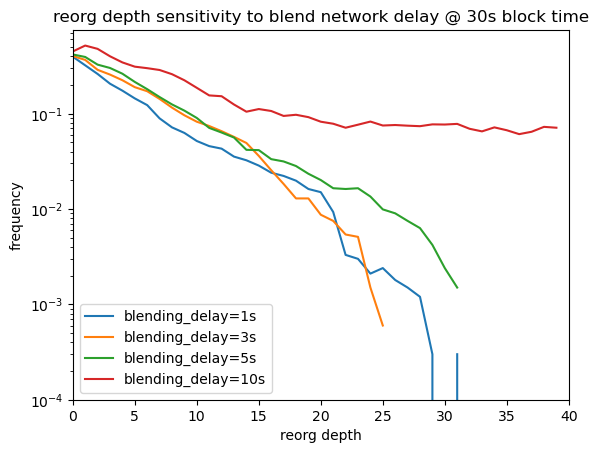

In [15]:
MAX=min(40, max(max(adv) for adv in advs))

for s in range(len(sims)):
    reorg_depth_analysis(sims[s], advs[s], MAX, label=f"blending_delay={sims[s].network.blending_delay}s")

_ = plt.title(f"reorg depth sensitivity to blend network delay @ {1/sims[s].params.f:.0f}s block time")
_ = plt.xlabel("reorg depth")
_ = plt.ylabel("frequency")
_ = plt.legend()
_ = plt.yscale("log")
_ = plt.xlim(0, MAX)
_ = plt.ylim(10**-4,None)
# _ = plt.

In [16]:
%%time
PATHS = 5
target_block_num = 30000
np.random.seed(0)
stake = np.random.pareto(10, 1000)
network = blend_net
sim_params = Params(
    SLOTS=0,
    f=0.05,
    adversary_control = 0.49,
    honest_stake = stake
)
np.random.seed(1)
sims = [Sim(
    params=replace(
        sim_params,
        SLOTS=int(target_block_num * block_time),
        f=1/block_time
    ),
    network=network
) for block_time in np.array([30]).repeat(PATHS)]


for i, sim in enumerate(sims):
    print(f"simulating {i+1}/{len(sims)}")
    sim.run(seed=i)

print("finished simulation, starting analysis")
advs = [sim.adverserial_analysis() for sim in sims]

print("cardano parameters")
cardano_block_time = 20
cardano_sims = [Sim(
    params=replace(
        sim_params,
        SLOTS=int(target_block_num * cardano_block_time),
        f=1/cardano_block_time,
    ),
    network=replace(network, blend_hops=0)
) for _ in range(PATHS)]

for i, sim in enumerate(cardano_sims):
    print(f"simulating {i+1}/{len(cardano_sims)}")
    sim.run(seed=i)

cardano_advs = [sim.adverserial_analysis() for sim in cardano_sims]

simulating 1/5
leader	17.13s
emit	2.32s
slot	19.46s
forkchoice	0.29s
emit_leader_block	0.43s
prep	0.00s
total	19.62s
simulating 2/5
leader	16.95s
emit	2.25s
slot	19.20s
forkchoice	0.28s
emit_leader_block	0.38s
prep	0.00s
total	19.37s
simulating 3/5
leader	16.92s
emit	2.26s
slot	19.18s
forkchoice	0.28s
emit_leader_block	0.41s
prep	0.00s
total	19.34s
simulating 4/5
leader	17.43s
emit	2.41s
slot	19.84s
forkchoice	0.30s
emit_leader_block	0.49s
prep	0.00s
total	20.01s
simulating 5/5
leader	17.40s
emit	2.46s
slot	19.86s
forkchoice	0.30s
emit_leader_block	0.52s
prep	0.00s
total	20.03s
finished simulation, starting analysis
Processing block Block(id=5000, slot=295115, height=4478, parent=np.int64(4999), leader=np.int64(924))
Processing block Block(id=10000, slot=579425, height=8965, parent=np.int64(9999), leader=np.int64(472))
Processing block Block(id=15000, slot=869955, height=13467, parent=np.int64(14999), leader=np.int64(210))
honest_chain	0.00s
honest_height_by_slot	0.00s
prep_analysis	1.

1 / 5
2 / 5
3 / 5
4 / 5
5 / 5


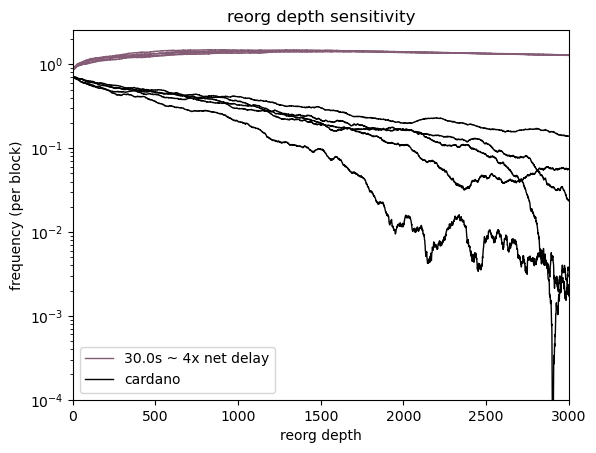

In [17]:
k = 3000
MAX=min(k, max(max(adv) for adv in advs))
network_samples = network.empirical_network_delay()
network_delay_mean = network_samples.mean()
f_index = list({s.params.f for s in sims})
hops_index = list({s.network.blend_hops for s in sims})
delay_index = list({s.network.blending_delay for s in sims})
colors = ['#855C75FF', '#D9AF6BFF', '#AF6458FF', '#736F4CFF', '#526A83FF', '#625377FF', '#68855CFF', '#9C9C5EFF', '#A06177FF', '#8C785DFF', '#467378FF', '#7C7C7CFF']

for s in range(len(sims)):
    print(f'{s+1} / {len(sims)}')
    block_time = 1 / sims[s].params.f
    c = colors[f_index.index(sims[s].params.f)]
    # c = colors[hops_index.index(sims[s].network.blend_hops)]
    # c = colors[delay_index.index(sims[s].network.blending_delay)]
    reorg_depth_analysis(sims[s], advs[s], MAX, color=c, lw="1", label=f"{block_time:.1f}s ~ {block_time / network_delay_mean:.0f}x net delay")
    # reorg_depth_analysis(sims[s], advs[s], MAX, color=c, lw="1", label=f"hops={sims[s].network.blend_hops}")
    # reorg_depth_analysis(sims[s], advs[s], MAX, color=c, lw="1", label=f"blending delay={sims[s].network.blending_delay}")


for s in range(len(cardano_sims)):
    reorg_depth_analysis(cardano_sims[s], cardano_advs[s], MAX, lw="1", color="k", label=f"cardano")

_ = plt.title(f"reorg depth sensitivity")
_ = plt.xlabel("reorg depth")
_ = plt.ylabel("frequency (per block)")
_ = plt.yscale("log")
_ = plt.xlim(0, MAX)
_ = plt.ylim(10**-4,None)

# avoid duplicate legend entries with the same label
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
_ = plt.legend(by_label.values(), by_label.keys())

# 30s Block Times Network Sensitivity Analysis

In [18]:
block_time = 30

nomos_params = Params(
    SLOTS=3 * 2160 * block_time,
    f=1/block_time,
    adversary_control = 0.3,
    honest_stake = np.random.pareto(10, 1000)
)
nomos_net = NetworkParams(
    broadcast_delay_mean=0.5,
    pol_proof_time=1,
    blending_delay=3,
    desimenation_delay_mean=0.5,
    blend_hops=3,
)

cardano_params = replace(nomos_params, f=1/20, SLOTS=10 * 2160 * 20)
cardano_net = replace(nomos_net, blend_hops=0)

leader	8.54s
emit	1.51s
slot	10.05s
forkchoice	0.31s
emit_leader_block	0.42s
prep	0.00s
total	10.14s
Processing block Block(id=5000, slot=142190, height=4884, parent=np.int64(4999), leader=np.int64(162))
Processing block Block(id=10000, slot=281660, height=9781, parent=np.int64(9999), leader=np.int64(896))
Processing block Block(id=15000, slot=422412, height=14683, parent=np.int64(14999), leader=np.int64(629))
honest_chain	0.00s
honest_height_by_slot	0.00s
prep_analysis	0.43s
nearest_honest	0.01s
reorg_events	4.62s
reorg_depth	0.22s
depth_append	0.02s


(array([28.,  3.,  2.,  1.,  1.,  1.,  0.,  1.,  0.,  1.]),
 array([5.0000e+00, 8.3640e+02, 1.6678e+03, 2.4992e+03, 3.3306e+03,
        4.1620e+03, 4.9934e+03, 5.8248e+03, 6.6562e+03, 7.4876e+03,
        8.3190e+03]),
 <BarContainer object of 10 artists>)

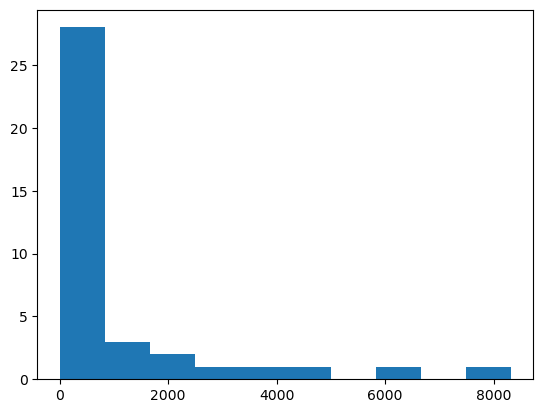

In [19]:
cardano_params = replace(nomos_params, f=1/20, SLOTS=10 * 2160 * 20)
cardano_net = replace(nomos_net, blend_hops=0)

cardano_sim = Sim(
    params=cardano_params,
    network=cardano_net
)
cardano_sim.run(seed=0)

cardano_reorgs = cardano_sim.adverserial_analysis()

plt.hist(np.bincount(cardano_reorgs))
    

In [20]:
%%time
test_params(nomos_params, nomos_net)

NameError: name 'test_params' is not defined